## Function Coverage Guided Fuzzer

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# @Author : Lizhi Liao (40048329)

from fuzzingbook.Fuzzer import RandomFuzzer
from fuzzingbook.MutationFuzzer import MutationFuzzer
from fuzzingbook.Coverage import Coverage

import random
import sys

Mian Compnents is Function Coverage Guided Fuzzer:
1. component that traces the function calls during execution
2. component that calculates the number of function calls for each fuzzing input value
3. component that maintain the main process of the coverage-guided algorithm
4. component that maintain the main process of the pure randomly algorithm¶
5. component that compare the random fuzzer and function coverage-guided fuzzer

Instead of performing blackbox fuzzing which does not have any information of the source code, nor how the code is executed, now we can improve our fuzzer by integrating the coverage information.

In this work, we especially focus on the Funciton Coverage of the test input.

#### the component below is testing program which is responsible for testing our fuzzer

In [2]:
def is_valid_email(email):
    """This is an example test program for the 
    function coverage guided fuzzy testing.
    Since it is not our focus, it may 
    contain some defects in this program.
    """
    try:
        # split email into id and domian
        email_id, email_domain = split_email_elements(email, '@')
        
        # check the domain name
        valid_domain = check_domain_name(email_domain)
                
        # check the user name
        if valid_domain:
            res = check_user_name(email_id)
            return res
        else:
            return False
    except:
        return False
    
    
def split_email_elements(obj, seperator):
    email_elems = obj.split(seperator)
    if len(email_elems) == 2:
        email_id, email_domain = email_elems
        return email_id, email_domain
        
def check_domain_name(email_domain):
    valid_domain = True
    for domain_char in email_domain:
        if domain_char.isalpha() or domain_char in ['@', '-', '.'] or domain_char.isdigit():
            continue
        else:
            valid_domain = False
    return valid_domain

def check_user_name(email_id):
    # now check the email local-part
    if len(email_id) > 64:
        return False
    else:
        if ' ' in email_id:
            if '"' not in email_id:
                return False
            elif email_id.index('"') < email_id.index(' '):
                return True
        else:
            return True

#### the function below is responsible for tarcing the funciton calls when program is in execution

In [3]:
def trace_calls(frame, event, arg):
    global coverage
    if event != 'call':
        return
    co = frame.f_code
    func_name = co.co_name
    func_line_no = frame.f_lineno
    func_filename = co.co_filename
    if func_filename.find('anaconda3') != -1:
        # Ignore calls not in this module
        return
    caller = frame.f_back
    caller_line_no = caller.f_lineno
    caller_filename = caller.f_code.co_filename
    
#     print('* Call to', func_name)
#     print('*  on line {} of {}'.format(
#         func_line_no, func_filename))
#     print('*  from line {} of {}'.format(
#         caller_line_no, caller_filename))
    
    coverage.append(func_name + str(func_line_no) + func_filename)
    return

# simple testing for the trace calls
def b():
    print('inside b()\n')


def a(a):
    print('inside a()\n')
    b()

#### the function below is responsible for execting the funciton and return the number of the function calls for the input

In [4]:
def execute_and_trace(fun, inp):
    global coverage
    coverage = []
    sys.settrace(trace_calls)  # Turn on
    fun(inp)
    sys.settrace(None)    # Turn off
    return coverage

# simple test for execute_and_trace

# inp = "kdjalkdjf@c@s.com"
# execute_and_trace(is_valid_email, inp)

#### the function below is responsible for calculating the function coverage information of all input_population

In [5]:
def calculate_coverage(input, funtion):
    coverage_score = []
    for inp in input:
        try:
            coverage_score.append(len(execute_and_trace(funtion, inp)))
        except:
            # we ignore exceptions for the purpose of this code, but some exceptions may be interesting
            pass
    return coverage_score

### Random Fuzzing 

In [6]:
trials = 100
seed_initial = 'abcd@ef@g.dfadf@.com'
covered_function_count_list_random = []

In [7]:
mutation_fuzzer = MutationFuzzer(seed=[seed_initial])

for trail in range(trials):
    inp = mutation_fuzzer.fuzz()
    coverage_score = calculate_coverage([inp], is_valid_email)
    covered_function_count_list_random.append(max(coverage_score))

#### from the following result, we can observe that the random fuzzing cannot help the fuzzer improve the function call coverage

In [8]:
covered_function_count_list_random

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 4,
 2]

### Function Call Coverage-guided Fuzzing 

In [9]:
trials = 100
seed_initial = 'abcd@ef@g.dfadf@.com'
seed_generated = []
covered_function_count_list_guided = []

In [10]:
for trail in range(trials):
    if not seed_generated:
        seed = seed_initial
    else:
        seed = seed_generated[0]
        seed_generated.remove(seed)
        seed = seed[0]
    
    mutation_fuzzer = MutationFuzzer(seed=[seed])
    input = []
    number_of_fuzzing = 3
    for i in range(number_of_fuzzing):
        inp = mutation_fuzzer.fuzz()
        input.append(inp)

    coverage_score = calculate_coverage(input, is_valid_email)
    
    covered_function_count_list_guided.append(max(coverage_score))
    
    for i in range (number_of_fuzzing): 
        seed_generated.append((input[i], coverage_score[i]))
                
    seed_generated.sort(key=lambda tup: tup[1], reverse=True)

#### from the following result, we can observe that, the function call guided fuzzing can help the fuzzer improve the function call coverage

In [11]:
covered_function_count_list_guided

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4]

### The comparasion between Random Fuzzing  and  Function Call Coverage-guided Fuzzing 

#### from the following result, we can observe that the function call guided fuzzing can help the fuzzer improve the function call coverage. You can also find in the plot that Function Call Coverage-guided Fuzzing increases the coverage for the inputs when we perfrom multiple trails.

Text(0, 0.5, 'Function Call Coverage')

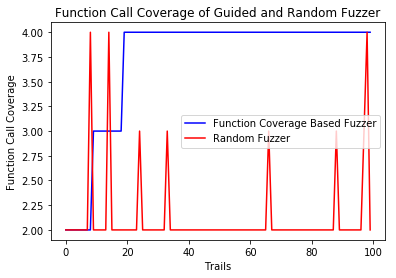

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.plot(covered_function_count_list_guided, 'b', label='Function Coverage Based Fuzzer')
plt.plot(covered_function_count_list_random, 'r', label='Random Fuzzer')
plt.legend()
plt.title('Function Call Coverage of Guided and Random Fuzzer')
plt.xlabel('Trails')
plt.ylabel('Function Call Coverage')
